In [ ]:
pip install diffusers transformers accelerate opencv-python facenet-pytorch

In [ ]:
import numpy as np
from diffusers.utils import load_image
from google.colab import files  # For Google Colab
from PIL import Image  # For image resizing

# Upload the image (Google Colab only)
uploaded = files.upload()
# Get the filename of the uploaded image
filename = list(uploaded.keys())[0]

# 이미지 불러오기
image = load_image("/content/" + filename)

# Resize the image
new_width = 512  # Example width; adjust as needed
new_height = 512 # Example height; adjust as needed
resized_image = image.resize((new_width, new_height))

# 이미지 로드
image = np.array(resized_image) # Convert PIL Image to NumPy array
image

In [ ]:
import cv2
import torch
from facenet_pytorch import MTCNN
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow

# 얼굴 검출 및 특징점 추출 모델
mtcnn = MTCNN()

def get_face_landmarks(image):
    # 얼굴 검출 및 특징점 추출
    boxes, _, landmarks = mtcnn.detect(image, landmarks=True)
    return landmarks

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # OpenCV는 BGR, RGB로 변경

# 얼굴 특징점 추출
landmarks = get_face_landmarks(image)

# 얼굴 특징점 시각화 (Colab에서 사용)
if landmarks is not None:
    for landmark in landmarks:
        for x, y in landmark:
            cv2.circle(image, (int(x), int(y)), 1, (0, 255, 0), -1)
    cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Use cv2_imshow
    cv2.waitKey(0)  # This line might not be necessary with cv2_imshow
    # cv2.destroyAllWindows()  # Not needed with cv2_imshow

In [ ]:
import cv2
import torch
from facenet_pytorch import MTCNN
import numpy as np
from google.colab.patches import cv2_imshow

# 얼굴 검출 및 특징점 추출 모델
mtcnn = MTCNN()

def get_extended_face_mask(image, extend_percentage=0.4):  # Added extend_percentage parameter
    boxes, probs = mtcnn.detect(image, landmarks=False)
    if boxes is not None:
        # Check if boxes is a single bounding box (1D array)
        if boxes.ndim == 1:
            # Reshape to a 2D array with one row
            boxes = boxes.reshape(1, -1)

        x1, y1, x2, y2 = boxes[0].astype(int) # Access the first box

        # Calculate extension amounts
        width = x2 - x1
        height = y2 - y1
        x_extend = int(width * extend_percentage)
        y_extend = int(height * extend_percentage)

        # Apply extensions (clamping to image boundaries)
        x1 = max(0, x1 - x_extend)
        y1 = max(0, y1 - y_extend)
        x2 = min(image.shape[1], x2 + x_extend) # Use image width for x2
        y2 = min(image.shape[0], y2 + y_extend) # Use image height for y2

        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)
        return mask, (x1, y1, x2, y2)
    return None, None


def get_face_mask(image):
    boxes, probs = mtcnn.detect(image, landmarks=False)  # landmarks=False is key
    if boxes is not None:
        # For simplicity, use the first detected face (handle multiple faces as needed)
        x1, y1, x2, y2 = boxes[0].astype(int)
        mask = np.zeros(image.shape[:2], dtype=np.uint8)  # Create mask
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)  # Fill rectangle
        return mask, (x1, y1, x2, y2) # return mask and box coordinates
    return None, None
# 이미지 로드 (PIL Image or NumPy array)
image = np.array(image) #PIL Image to array
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR, RGB로 변경

# 얼굴 마스크 생성
# mask, (x1, y1, x2, y2) = get_face_mask(image)
mask, (x1, y1, x2, y2) = get_extended_face_mask(image)


# 얼굴 영역 시각화 (Colab에서 사용)
if mask is not None:
    masked_image = image.copy()
    masked_image[mask > 0] = [0, 255, 0] # Color the masked region (green in this example) for visualization. You can modify this
    cv2_imshow(cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)

    #Or, if you just want to see the mask
    cv2_imshow(mask)
    cv2.waitKey(0)

Unique classes: [ 0  1  3  8 13 17 18]


<ipython-input-11-59386233df32>:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_classes))  # You can change 'viridis' to other colormaps


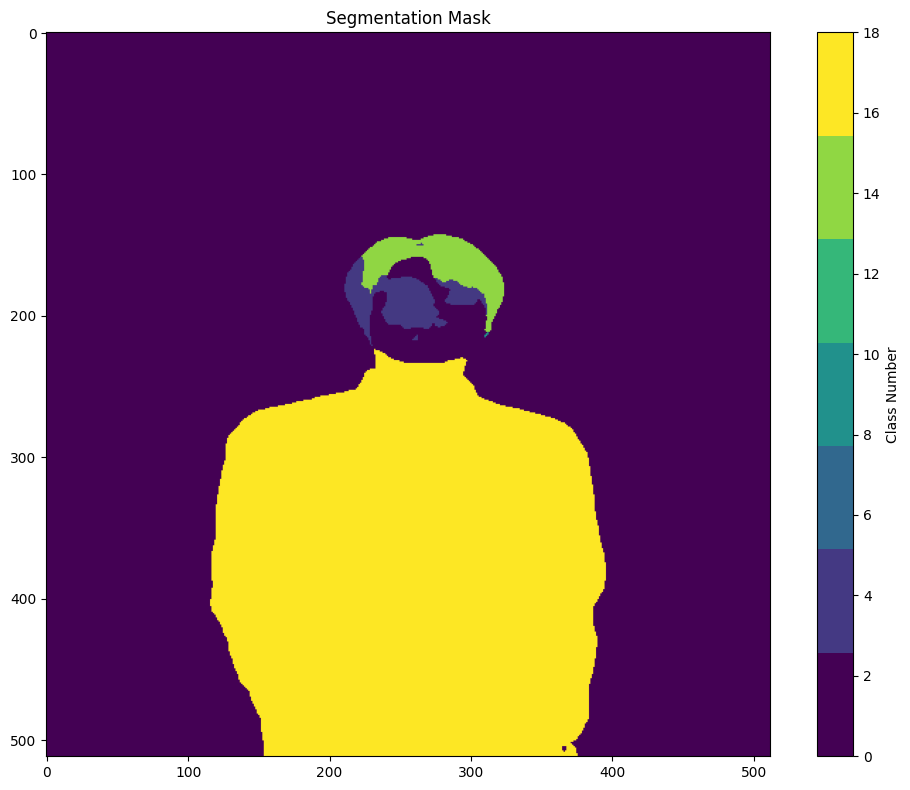

Unique classes: [0 1]


<ipython-input-11-59386233df32>:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_classes))  # You can change 'viridis' to other colormaps


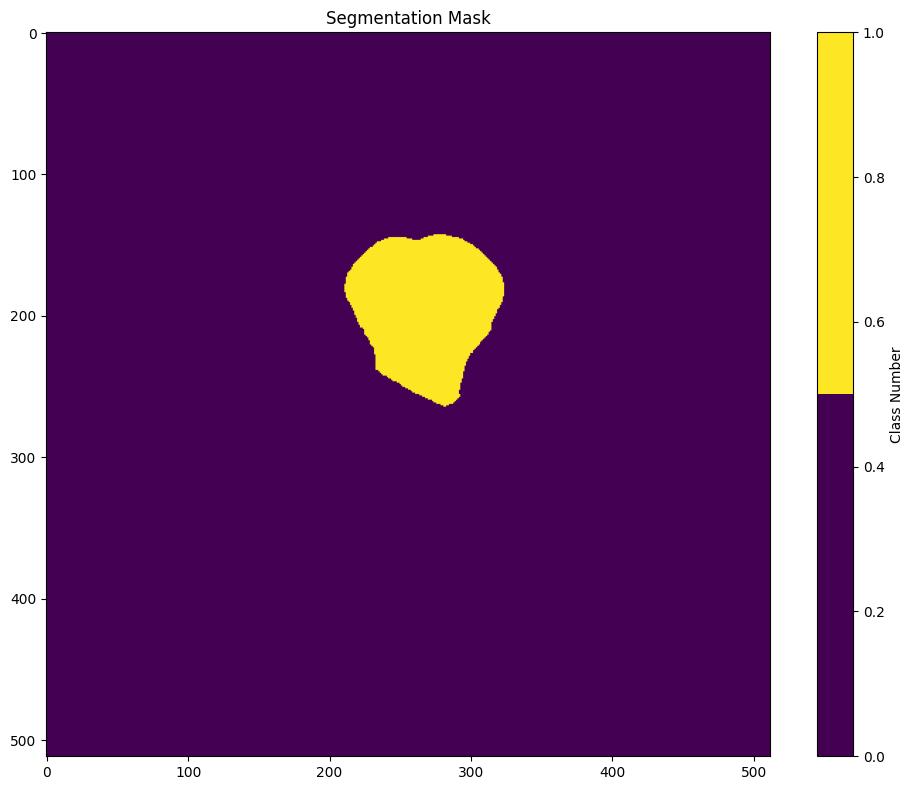

In [11]:
import torch
from torch import nn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import requests

# convenience expression for automatically determining device
device = (
    "cuda"
    # Device for NVIDIA or AMD GPUs
    if torch.cuda.is_available()
    else "mps"
    # Device for Apple Silicon (Metal Performance Shaders)
    if torch.backends.mps.is_available()
    else "cpu"
)

# load models
image_processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
model.to(device)

# run inference on image
inputs = image_processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, ~height/4, ~width/4)

# resize output to match input image dimensions
# Use image.shape instead of image.size and reverse using [::-1]
upsampled_logits = nn.functional.interpolate(logits,
                size=image.shape[0:2][::-1], # H x W # Use image.shape and reverse the order of height and width for size
                mode='bilinear',
                align_corners=False)

# get label masks
labels = upsampled_logits.argmax(dim=1)[0]

# move to CPU to visualize in matplotlib
labels_viz = labels.cpu().numpy()

# 1. Get unique class numbers
unique_classes = np.unique(labels_viz)
print("Unique classes:", unique_classes)

# 2. Create a colormap and legend
cmap = plt.cm.get_cmap('viridis', len(unique_classes))  # You can change 'viridis' to other colormaps
colors = [cmap(i) for i in range(len(unique_classes))]


# 3. Display the segmented image with the legend
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
plt.imshow(labels_viz, cmap=cmap)  # Use the colormap

plt.title("Segmentation Mask")
plt.colorbar(label="Class Number") # Add a colorbar
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

face_viz = np.where((labels_viz != 0) & (labels_viz != 18), 1, 0)
# 1. Get unique class numbers
unique_classes = np.unique(face_viz)
print("Unique classes:", unique_classes)

# 2. Create a colormap and legend
cmap = plt.cm.get_cmap('viridis', len(unique_classes))  # You can change 'viridis' to other colormaps
colors = [cmap(i) for i in range(len(unique_classes))]


# 3. Display the segmented image with the legend
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
plt.imshow(face_viz, cmap=cmap)  # Use the colormap

plt.title("Segmentation Mask")
plt.colorbar(label="Class Number") # Add a colorbar
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

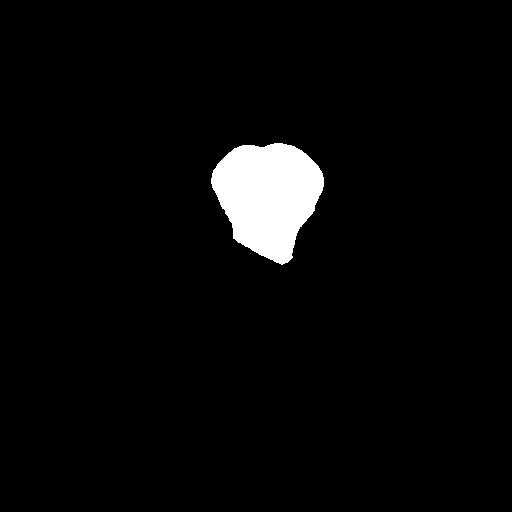

In [13]:
import cv2

# Convert image and mask to PIL Images (required for inpainting pipeline)
image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
mask_array = np.where(face_viz == 1, 0, 255).astype(np.uint8)
mask_pil = Image.fromarray(mask_array)
mask_pil

In [28]:
# from transformers import CLIPProcessor, CLIPModel

# processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
# model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

# image_np = np.array(image) # Convert PIL Image to NumPy arrayfrom transformers import CLIPTokenizer, CLIPModel

# # CLIP 모델 로드
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
# model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

def generate_prompt():
    # 얼굴 특징점 분석 및 닮은 동물 판단 (간략화)
    # 실제로는 더 복잡한 분석 필요
    animal = "dog"  # 임의로 고양이 선택
    return f"{animal}"

# 텍스트 프롬프트 생성
prompt = generate_prompt()

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline

# 허깅페이스 모델 저장소에서 사전 학습된 가중치를 다운로드합니다.
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",  # Stable Diffusion v2.1 기반 Inpainting 모델
    torch_dtype=torch.float16,  # 메모리 효율성을 위해 float16 정밀도 사용 (선택 사항)
).to("cuda")  # GPU 사용 (선택 사항)

# 이미지 생성 (Inpainting)
animal_image = pipe(prompt=prompt,
                   image=image_pil, # original image
                   mask_image=mask_pil, # the mask
                   num_inference_steps=30,
                   guidance_scale=9).images[0]
animal_image

In [ ]:
import numpy as np

def composite_images(original_image, animal_image, landmarks):
    # 얼굴 영역 마스크 생성 (간략화)
    # 실제로는 얼굴 윤곽선을 이용하여 마스크 생성
    mask = np.zeros_like(original_image[:, :, 0], dtype=np.uint8)
    x_min = int(min(landmarks[0][:, 0]))
    y_min = int(min(landmarks[0][:, 1]))
    x_max = int(max(landmarks[0][:, 0]))
    y_max = int(max(landmarks[0][:, 1]))
    cv2.rectangle(mask, (x_min, y_min), (x_max, y_max), 255, -1)

    # 동물 이미지 크기 조정 및 합성
    animal_image = cv2.resize(animal_image, (x_max - x_min, y_max - y_min))
    composite_image = original_image.copy()
    composite_image[y_min:y_max, x_min:x_max] = animal_image

    return composite_image

# 이미지 합성
composite_image = composite_images(image, np.array(animal_image), landmarks)

# 합성된 이미지 저장 및 출력
cv2_imshow(cv2.cvtColor(composite_image, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def get_face_mask(image):
    boxes, probs = mtcnn.detect(image, landmarks=False)  # landmarks=False is key
    if boxes is not None:
        # For simplicity, use the first detected face (handle multiple faces as needed)
        x1, y1, x2, y2 = boxes[0].astype(int)
        mask = np.zeros(image.shape[:2], dtype=np.uint8)  # Create mask
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)  # Fill rectangle
        return mask, (x1, y1, x2, y2) # return mask and box coordinates
    return None, None
# 이미지 로드 (PIL Image or NumPy array)
image = np.array(image) #PIL Image to array
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR, RGB로 변경

# 얼굴 마스크 생성
# mask, (x1, y1, x2, y2) = get_face_mask(image)
mask, (x1, y1, x2, y2) = get_extended_face_mask(image)


# 얼굴 영역 시각화 (Colab에서 사용)
if mask is not None:
    masked_image = image.copy()
    masked_image[mask > 0] = [0, 255, 0] # Color the masked region (green in this example) for visualization. You can modify this
    cv2_imshow(cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)

    #Or, if you just want to see the mask
    cv2_imshow(mask)
    cv2.waitKey(0)

import numpy as np

def composite_images(original_image, animal_image, mask):
    # 얼굴 영역 마스크 생성 (간략화)
    # 실제로는 얼굴 윤곽선을 이용하여 마스크 생성
    mask = np.zeros_like(original_image[:, :, 0], dtype=np.uint8)
    # x_min = int(min(landmarks[0][:, 0]))
    # y_min = int(min(landmarks[0][:, 1]))
    # x_max = int(max(landmarks[0][:, 0]))
    # y_max = int(max(landmarks[0][:, 1]))
    cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

    # 동물 이미지 크기 조정 및 합성
    animal_image = cv2.resize(animal_image, (x2 - x1, y2 - y1))
    composite_image = original_image.copy()
    composite_image[y1:y2, x1:x2] = animal_image

    return composite_image

# 이미지 합성
composite_image = composite_images(image, np.array(animal_image), mask)

# 합성된 이미지 저장 및 출력
cv2_imshow(cv2.cvtColor(composite_image, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()